## 뉴욕시의 Taxi 데이터 활용한 예측 모델
---
- 데이터셋 : 캐글의 NYC_taxi.csv (https://www.kaggle.com/code/yuzhangguo/nyc-taxi/notebook)
- 조건 : 뉴욕시 내
- 거리에 따른 요금 예측 => 회귀

### [1] 데이터 로딩

In [1]:
import pandas as pd

FILE='C:/Users/User/Data/taxi_train.csv'

# nrows=숫자 : 로딩할 데이터 조절
# parse_dates=['컬럼명'] : 데이트타임으로 변경  
df=pd.read_csv(FILE, nrows=50000, parse_dates=['pickup_datetime'])

In [2]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                50000 non-null  object             
 1   fare_amount        50000 non-null  float64            
 2   pickup_datetime    50000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   50000 non-null  float64            
 4   pickup_latitude    50000 non-null  float64            
 5   dropoff_longitude  50000 non-null  float64            
 6   dropoff_latitude   50000 non-null  float64            
 7   passenger_count    50000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 3.1+ MB


In [4]:
df.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

### [2] 결측치 및 이상치 체크

In [5]:
df.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [6]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,11.364171,-72.509756,39.933759,-72.504616,39.926251,1.667840
std,9.685557,10.393860,6.224857,10.407570,6.014737,1.289195
min,-5.000000,-75.423848,-74.006893,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992062,40.734880,-73.991152,40.734372,1.000000
50%,8.500000,-73.981840,40.752678,-73.980082,40.753372,1.000000
75%,12.500000,-73.967148,40.767360,-73.963584,40.768167,2.000000
max,200.000000,40.783472,401.083332,40.851027,43.415190,6.000000


In [7]:
# 뉴욕 위도 경도
df = df[(df["pickup_longitude"] <= -71.47) & (df["pickup_longitude"] >= -79.45)]
df = df[(df["pickup_latitude"] >= 40.29) & (df["pickup_latitude"] <= 45)]
df = df[(df["dropoff_longitude"] <= -71.47) & (df["dropoff_longitude"] >= -79.45)]
df = df[(df["dropoff_latitude"] >= 40.29) & (df["dropoff_latitude"] <= 45)]

# 요금 음수 지우기
df = df[df['fare_amount']>0]

In [8]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,48946.000000,48946.000000,48946.000000,48946.000000,48946.000000,48946.000000
mean,11.360258,-73.975160,40.751235,-73.973952,40.751696,1.669350
std,9.652504,0.040846,0.032914,0.039314,0.035975,1.290249
min,0.010000,-75.423848,40.307765,-75.354559,40.316153,0.000000
25%,6.000000,-73.992300,40.736522,-73.991332,40.735910,1.000000
50%,8.500000,-73.982121,40.753448,-73.980479,40.754124,1.000000
75%,12.500000,-73.968396,40.767768,-73.965320,40.768487,2.000000
max,200.000000,-72.856968,43.098708,-72.854940,43.415190,6.000000


### 특성 새롭게 생성 => 거리 Feature
---
- 공식: 루트(x2-x1)^2+(y2-y1)^2

In [9]:
df['distance']=((df['dropoff_longitude']-df['pickup_longitude'])**2+(df['dropoff_latitude']-df['pickup_latitude'])**2)**0.5
df

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,0.009436
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,0.079696
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0.013674
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,0.025340
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,0.019470
...,...,...,...,...,...,...,...,...,...
49995,2013-06-12 23:25:15.0000004,15.0,2013-06-12 23:25:15+00:00,-73.999973,40.748531,-74.016899,40.705993,1,0.045782
49996,2015-06-22 17:19:18.0000007,7.5,2015-06-22 17:19:18+00:00,-73.984756,40.768211,-73.987366,40.760597,1,0.008049
49997,2011-01-30 04:53:00.00000063,6.9,2011-01-30 04:53:00+00:00,-74.002698,40.739428,-73.998108,40.759483,1,0.020574
49998,2012-11-06 07:09:00.00000069,4.5,2012-11-06 07:09:00+00:00,-73.946062,40.777567,-73.953450,40.779687,2,0.007686


In [10]:
# 거리 0이상만 남기기
df=df[df['distance']>0]

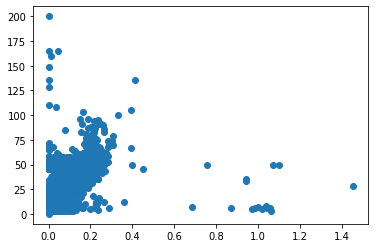

In [11]:
# 데이터 확인
import matplotlib.pyplot as plt
plt.scatter(df['distance'],df['fare_amount'])
plt.show()

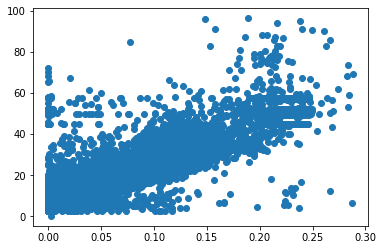

In [134]:
# 이상치 제거
df=df[(df['distance']<0.3) & (df['fare_amount']<100)]
plt.scatter(df['distance'],df['fare_amount'])
plt.show()

In [12]:
# 2차원배열로
import numpy as np
arrX=np.array(df['distance']).reshape(-1,1)
arrY=np.array(df['fare_amount'])

# 훈련 세트와 테스트 세트로 나눔
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(
arrX, arrY, random_state=42)

In [13]:
# 선형 회귀
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

# 선형 회귀 모델 훈련
lr.fit(train_input, train_target)


# 기울기(a): coef_, 절편(bias): intercept_
print(lr.coef_, lr.intercept_)

# 평가
print(lr.score(test_input, test_target))

[174.5811765] 5.268479412283713
0.6735097769781104


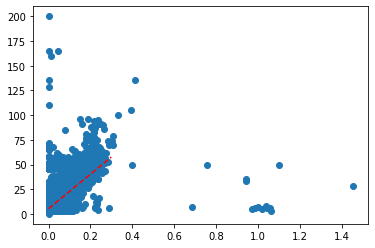

In [15]:
point=np.arange(0, 0.3, 0.001)

import matplotlib.pyplot as plt
plt.scatter(train_input,train_target)
plt.plot(point, 217*point +3.8, color='red', linestyle='--')
plt.show()